# Ejemplo Series de Tiempo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:

airPas = pd.read_csv('./AirPassengers.csv', parse_dates=['Month'], index_col='Month')
print ('\n Parsed Data:')
airPas.head()

airPas = pd.read_csv('./AirPassengers.csv')
airPas['Month'] = pd.to_datetime(airPas['Month'])
airPas.set_index('Month', inplace=True)


train_size = int(len(airPas) * 0.7)
train_airPas = airPas[0:train_size]
test_airPas = airPas[train_size:len(airPas)]



 Parsed Data:


In [4]:
ts_air_pas = train_airPas['#Passengers']
ts_air_pas.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [5]:
ts_air_pas[:'1949-5-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## Pasos para construir modelos ARIMA
1. Identificación
2. Estimación
3. Validación
4. Predicción

### Identificación


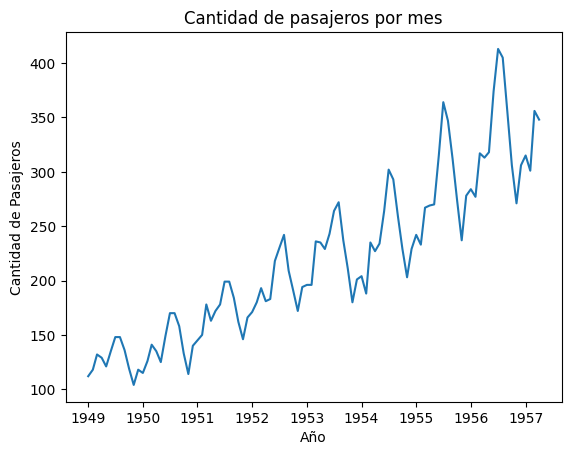

In [6]:
plt.plot(ts_air_pas)
plt.gca().set(title="Cantidad de pasajeros por mes", xlabel="Año", ylabel="Cantidad de Pasajeros")
plt.show()

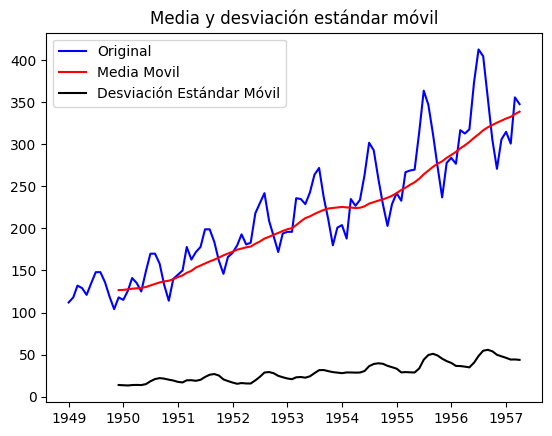

In [7]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = ts_air_pas.rolling(window=12).mean()
deMovil = ts_air_pas.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(ts_air_pas, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Se puede apreciar que existe cierta tendencia por lo que es posible que no sea estacionaria en media. Tampoco parece ser estacionaria en varianza pero podremos verlo mejor cuando descompongamos la serie en sus componentes.

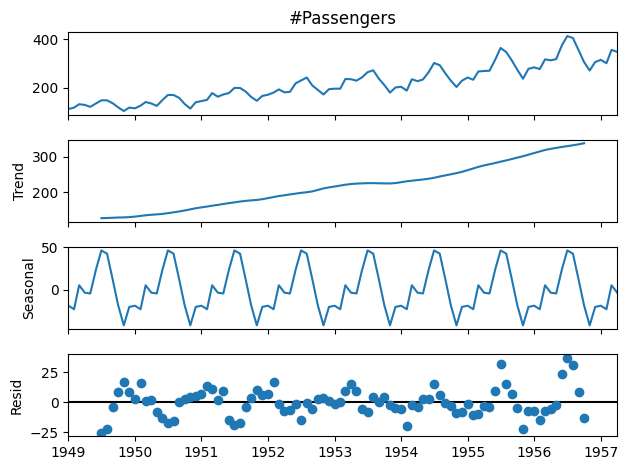

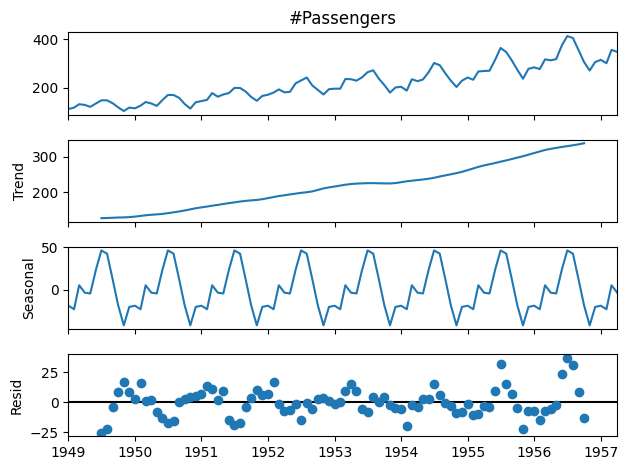

In [8]:
descomposicion = seasonal_decompose(ts_air_pas)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

## Estimar los parámetros del modelo

Lo primero que vamos a hacer es estacionarizar la serie. Ya que no es estacionaria en varianza le vamos a aplicar una transformación logaritmica y la volveremos a graficar.

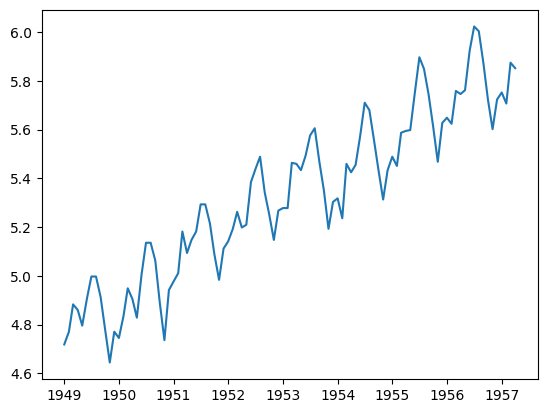

In [9]:
ts_air_pas_log = np.log(ts_air_pas)
plt.plot(ts_air_pas_log)

Con esta transformación pudimos estacionarizarla en varianza. Para ver si no es estacionaria en media (ya sabemos que tiene tendencia a aumentar con el paso del tiempo) aplicaremos la prueba de Dickey-fuller aumentada para comprobar que hay raíces unitarias.

In [10]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(ts_air_pas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         1.509804
p-value                       0.997560
# de retardos usados         12.000000
# de observaciones usadas    87.000000
Critical Value (1%)          -3.507853
Critical Value (5%)          -2.895382
Critical Value (10%)         -2.584824
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [11]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = ts_air_pas.diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -2.180602
p-value                       0.213361
# de retardos usados         12.000000
# de observaciones usadas    86.000000
Critical Value (1%)          -3.508783
Critical Value (5%)          -2.895784
Critical Value (10%)         -2.585038
dtype: float64


El p-value es mayor a 0.05, por lo que sigue siendo estacionaria en media. Probemos otra diferenciación

In [12]:
ts_air_pas_diff = ts_air_pas_diff.diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Estadístico de prueba       -1.217795e+01
p-value                      1.372387e-22
# de retardos usados         1.100000e+01
# de observaciones usadas    8.600000e+01
Critical Value (1%)         -3.508783e+00
Critical Value (5%)         -2.895784e+00
Critical Value (10%)        -2.585038e+00
dtype: float64


Ahora si dio significativo el p-valor, por lo que podemos decir que no hay raices unitarias

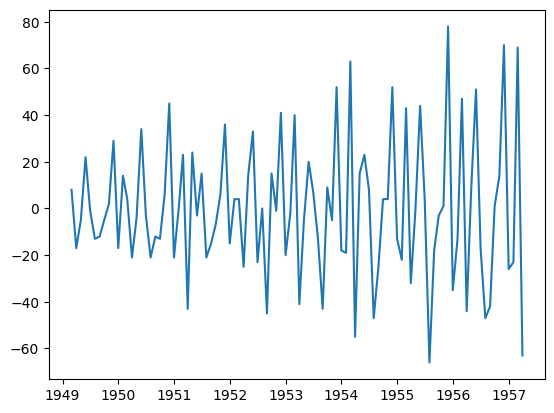

In [13]:
plt.plot(ts_air_pas_diff)

Las transformaciones realizadas fueron una transformación logaritmica y una diferenciación

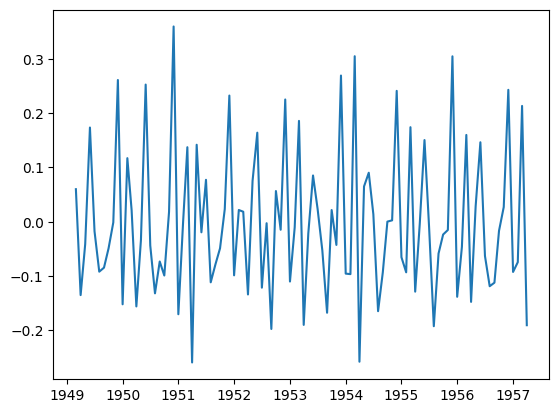

In [14]:
plt.plot(ts_air_pas_log.diff().diff())

Podemos decir que la serie es estacionaria ahora en media y en varianza. Toca ahora estimar los parámetros del modelo.

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  


In [15]:
ts_air_pas_log_diff = ts_air_pas_log.diff().diff()
ts_air_pas_log_diff.dropna(inplace = True)
tsa_acf = acf(ts_air_pas_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(ts_air_pas_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.32245025, -0.20543664,  0.15191504, -0.26964344,
        0.04263246])

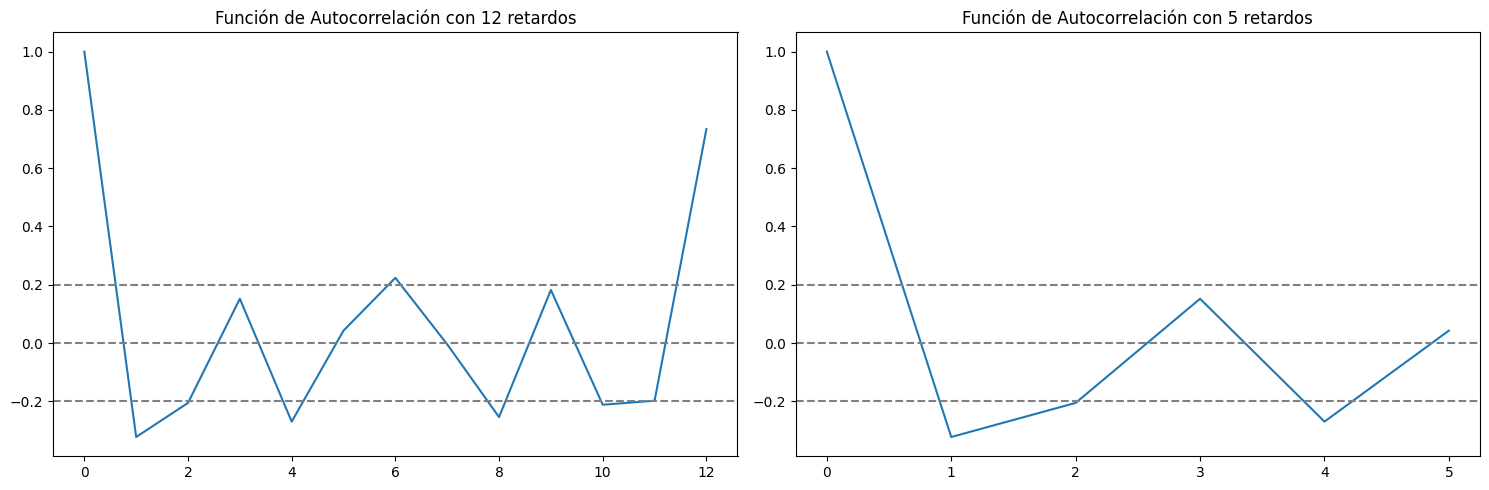

In [16]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(ts_air_pas_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(ts_air_pas_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

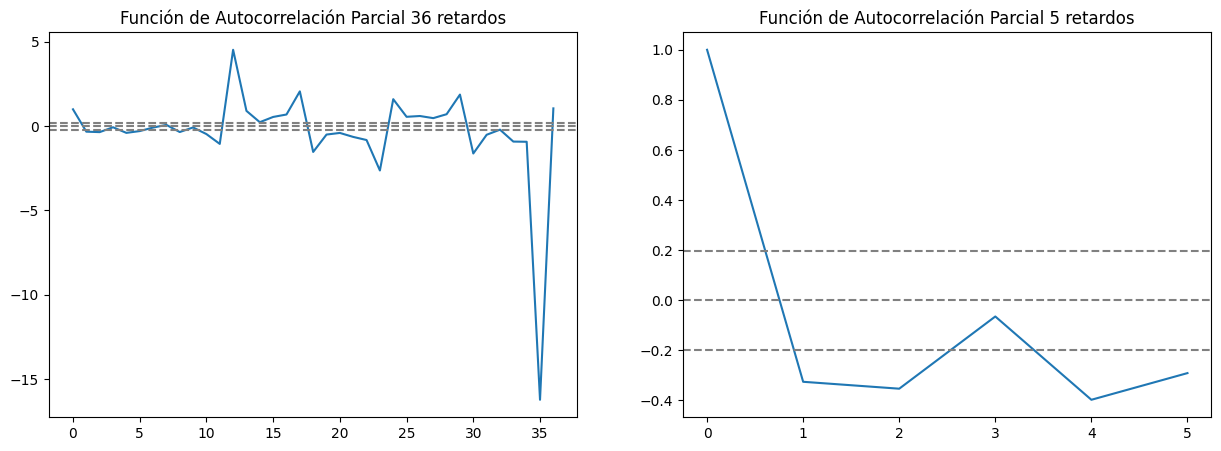

In [17]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(ts_air_pas_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(ts_air_pas_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=2, q=1
  
En ambos casos solo es necesaria una diferenciación por lo que d=2

#### Estacionalidad

Veamos ahora si hay estacionalidad en la serie. Hagamos un gráfico de la función de autocorrelación usando 36 resagos:


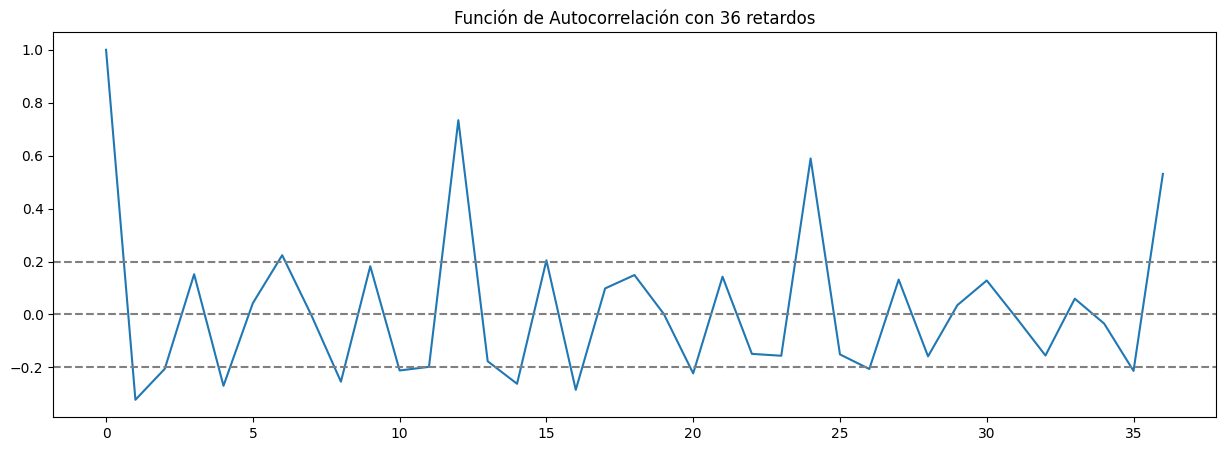

In [18]:
plt.plot(acf(ts_air_pas_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar para 12, 24, 36 meses por lo que hay una correlación entre los años, eso indica que hay estacionalidad cada 12 meses. Deberíamos agregarle el componente estacional

In [19]:
ts_air_pas_log_D = ts_air_pas_log.diff(12)
ts_air_pas_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

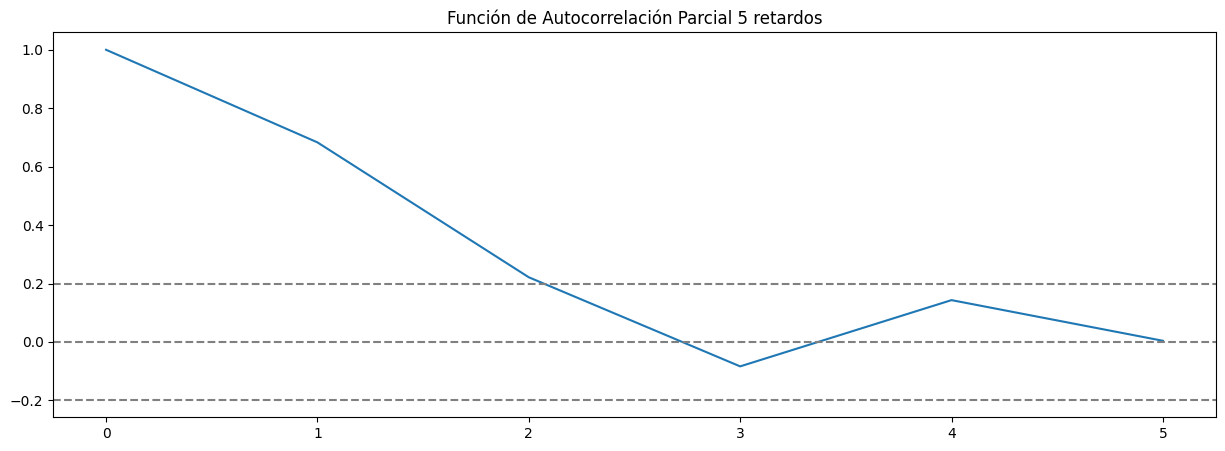

In [20]:

plt.plot(pacf(ts_air_pas_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_air_pas_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=2. Probemos el siguiente componente estacional:
- P = 2
- D = 1
- Q = 0

In [21]:
modelo121 = SARIMAX(ts_air_pas_log, order=(1,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])

c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2299      0.119     -1.928      0.054      -0.464       0.004
ma.L1         -1.0000     94.392     -0.011      0.992    -186.005     184.005
ar.S.L12      -0.4929      0.106     -4.655      0.000      -0.700      -0.285
ar.S.L24      -0.2360      0.118     -1.995      0.046      -0.468      -0.004
sigma2         0.0014      0.136      0.011      0.992      -0.264       0.267


Análisis de residuos

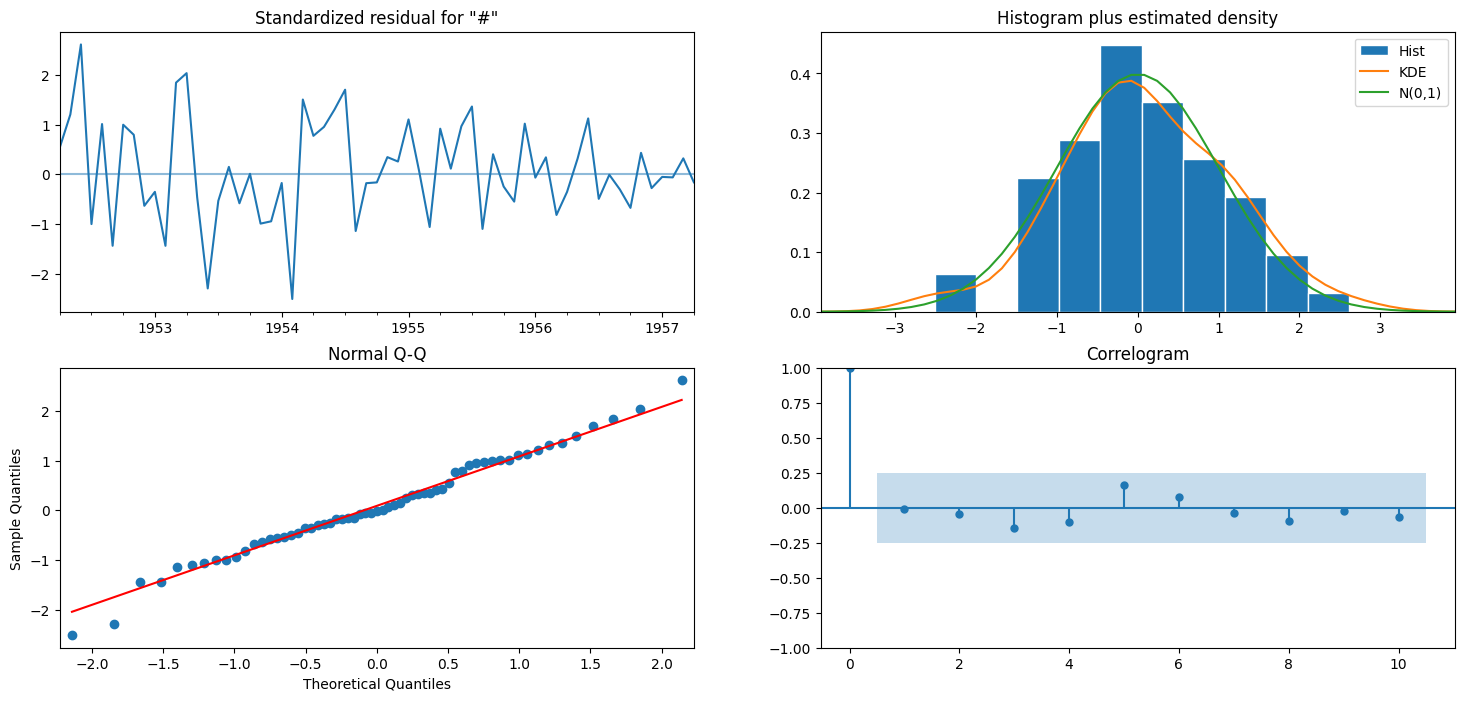

In [22]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

 Como se puede obserevar los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [23]:
modelo221 = SARIMAX(ts_air_pas_log, order=(2,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m221 = modelo221.fit()
print(resultado_m221.summary().tables[1])

c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2386      0.134     -1.783      0.075      -0.501       0.024
ar.L2         -0.0453      0.146     -0.311      0.756      -0.331       0.240
ma.L1         -1.0000    164.569     -0.006      0.995    -323.548     321.548
ar.S.L12      -0.4937      0.109     -4.525      0.000      -0.707      -0.280
ar.S.L24      -0.2328      0.120     -1.934      0.053      -0.469       0.003
sigma2         0.0014      0.238      0.006      0.995      -0.466       0.469


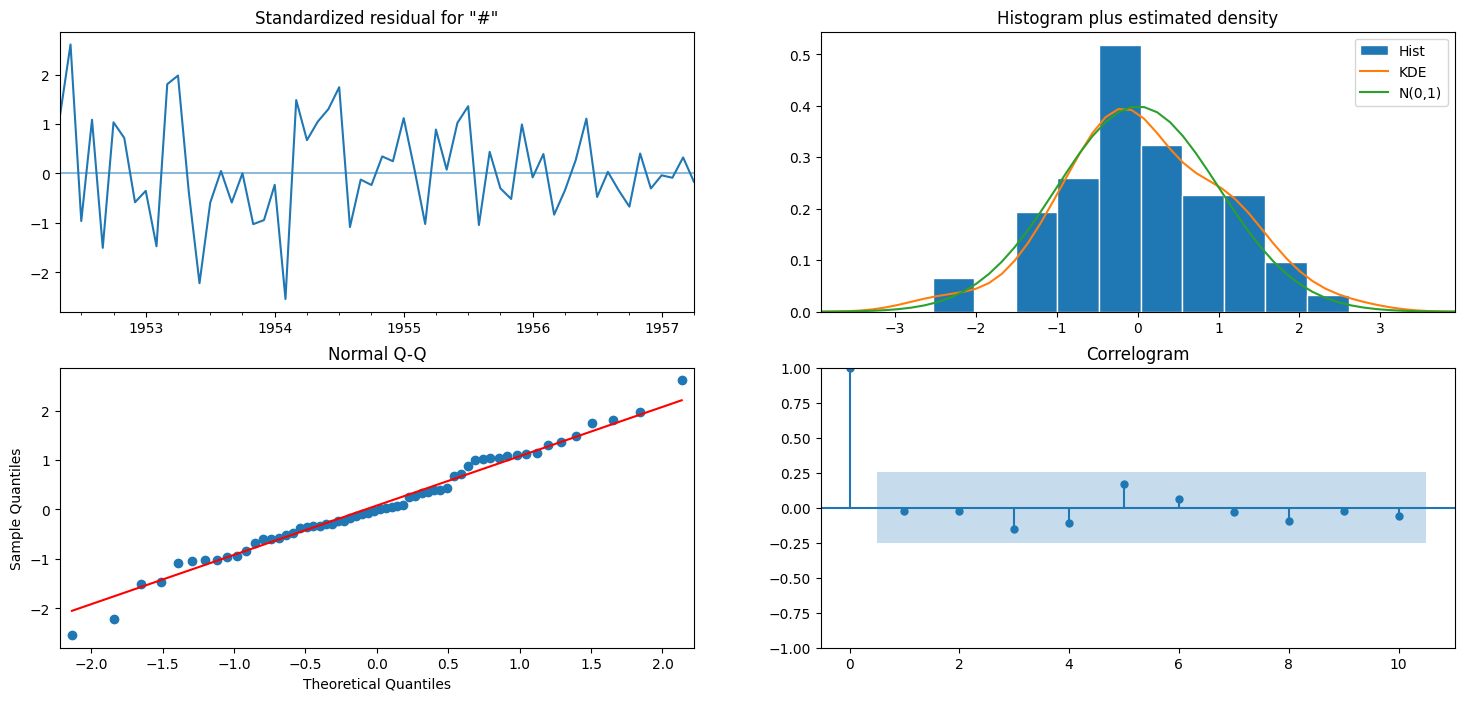

In [24]:
resultado_m221.plot_diagnostics(figsize=(18, 8))
plt.show()

En este otro modelo tampoco existen autocorrelaciones significativas y parecen estar distribuidos de forma normal

In [25]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_m121.aic)
print("Modelo 221=",resultado_m221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_m121.bic)
print("Modelo 221=",resultado_m221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -212.5790505630726
Modelo 221= -206.7675217780227
Resultados de BIC (Bayesian information criterion)
Modelo 121= -202.02468124220604
Modelo 221= -194.2014544046901


De acuerdo a ambos indicadores es mejor el modelo p=1, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Predicción con el mejor modelo

In [26]:
test_airPas.index[0]
print(airPas.dtypes)

#Passengers    int64
dtype: object


1957-05-01    5.869439
1957-06-01    6.018287
1957-07-01    6.136579
1957-08-01    6.106209
1957-09-01    5.981973
1957-10-01    5.843235
1957-11-01    5.714931
1957-12-01    5.844962
1958-01-01    5.877180
1958-02-01    5.837772
1958-03-01    5.988674
1958-04-01    5.974649
1958-05-01    5.987338
1958-06-01    6.139871
1958-07-01    6.258462
1958-08-01    6.225751
1958-09-01    6.102809
1958-10-01    5.962648
1958-11-01    5.831147
1958-12-01    5.964948
1959-01-01    5.992774
1959-02-01    5.954223
1959-03-01    6.104693
1959-04-01    6.087747
1959-05-01    6.101352
1959-06-01    6.254223
1959-07-01    6.367161
1959-08-01    6.337157
1959-09-01    6.210801
1959-10-01    6.068032
1959-11-01    5.938723
1959-12-01    6.067646
1960-01-01    6.095876
1960-02-01    6.054476
1960-03-01    6.208154
1960-04-01    6.189596
1960-05-01    6.202824
1960-06-01    6.353661
1960-07-01    6.468317
1960-08-01    6.436533
1960-09-01    6.310557
1960-10-01    6.168410
1960-11-01    6.037777
1960-12-01 

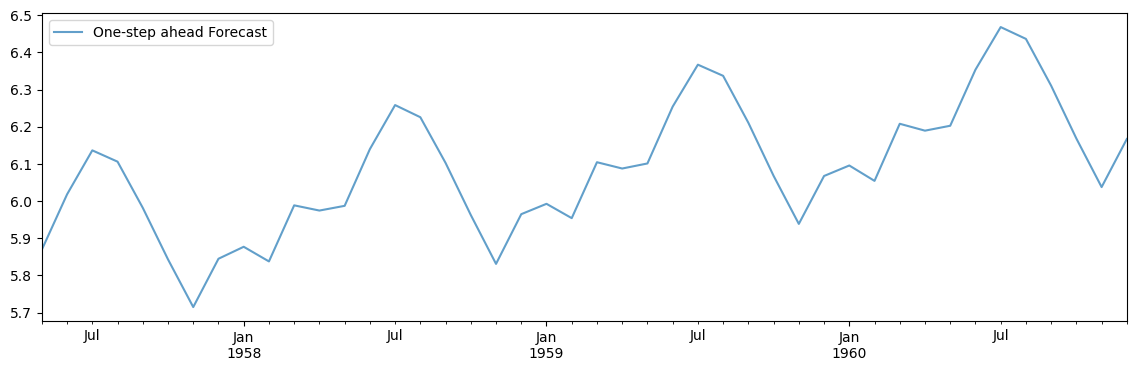

In [29]:
pred = resultado_m121.get_prediction(start=test_airPas.index[0], dynamic=False, end=test_airPas.index[-1])
print(pred.predicted_mean)
pred_ci = pred.conf_int()
# ax = airPas['1949':].plot(label='observed')
pred.predicted_mean.plot(label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
# ax.fill_between( pred_ci.iloc[:,0],
#                 pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
# ax.fill_between(pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

# Agregar los resultados verdaderos al gráfico
# test_airPas.plot(ax=ax, label='Resultados verdaderos', color='red')
plt.legend()
plt.show()

pred